In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

high_fee = pd.read_parquet('lp_analysis_output_weth_dai_events_3000.parquet')
low_fee = pd.read_parquet('lp_analysis_output_weth_dai_events_500.parquet')

high_fee['date'] = pd.to_datetime(high_fee.evt_block_time).dt.normalize()
low_fee['date'] = pd.to_datetime(low_fee.evt_block_time).dt.normalize()



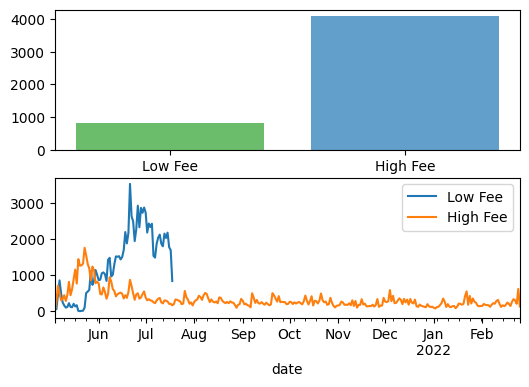

In [2]:
lp_cols_high = [i for i in high_fee.columns if ('fee' not in i) & ('inventory' not in i)]
lp_cols_low = [i for i in low_fee.columns if ('fee' not in i) & ('inventory' not in i)]

low_fee['volume_proxy'] = abs(low_fee['amount0']) + abs(low_fee['amount1'])
high_fee['volume_proxy'] = abs(high_fee['amount0']) + abs(high_fee['amount1'])

daily_vol_low = low_fee.groupby('date').size()
daily_vol_high = high_fee.groupby('date').volume_proxy.size()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=False)

daily_vol_low.plot(ax=ax2,label = 'Low Fee')
daily_vol_high.plot(ax=ax2, label = 'High Fee')

n_lps_low = len(lp_cols_low)
n_lps_high = len(lp_cols_high)

ax1.bar(['Low Fee', 'High Fee'], [n_lps_low, n_lps_high], color=['tab:green', 'tab:blue'], alpha=0.7)
plt.legend()


In [ ]:

exclude_cols = ['amount0','amount1','event','date','evt_block_time','price','pool_liquidity','volume_proxy',"('0x', 0.0, 0.0)"]
just_lps = [i for i in lp_cols_high if i not in exclude_cols]
high_lps = pd.DataFrame(index = just_lps)

for lp in just_lps:
    high_lps.loc[lp,'position_size'] = high_fee[lp].astype(float).max()
    high_lps.loc[lp,'lifetime'] = (high_fee[lp] > 0).sum()
    fee_0_str = lp + '_fee_0'
    fee_1_str = lp + '_fee_1'
    dollars_fees = (high_fee.price * high_fee[fee_0_str]) + (high_fee[fee_1_str]) #double check this 
    high_lps.loc[lp,'total_fees'] = dollars_fees.sum()

    

In [14]:
exclude_cols = ['amount0','amount1','event','date','evt_block_time',
                'price','pool_liquidity','volume_proxy',"('0x', 0.0, 0.0)"]

just_lps_low = [i for i in lp_cols_low if i not in exclude_cols]

low_lps = pd.DataFrame(index=just_lps_low)

for lp in just_lps_low:
    low_lps.loc[lp, 'position_size'] = low_fee[lp].astype(float).max()
    low_lps.loc[lp, 'lifetime'] = (low_fee[lp] > 0).sum()
    
    fee_0_str = lp + '_fee_0'
    fee_1_str = lp + '_fee_1'
    
    dollars_fees = (low_fee['price'] * low_fee[fee_0_str]) + low_fee[fee_1_str]
    low_lps.loc[lp, 'total_fees'] = dollars_fees.sum()

(-3.0, 3.0)

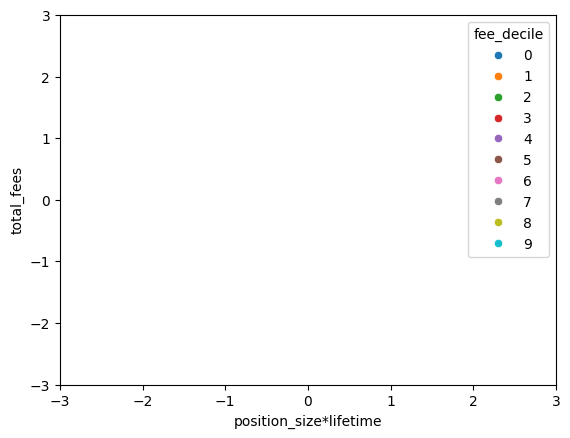

In [15]:
from scipy import stats 
import seaborn as sns

n_bins = 10
labels = list(range(n_bins))

high_lps['liquidity_decile'] = pd.qcut(high_lps['position_size'], q=n_bins, labels=labels).astype(int)
high_lps['lifetime_decile'] = pd.qcut(high_lps['lifetime'], q=n_bins, labels=labels).astype(int)
high_lps['fee_decile'] = pd.qcut(high_lps['total_fees'], q=n_bins, labels=labels).astype(int)
high_lps['position_size*lifetime'] = high_lps['position_size'] * high_lps['lifetime']
high_lps['total_fees'] = high_lps.total_fees

sns.scatterplot(
    data = high_lps,
    x = 'position_size*lifetime',
    y = 'total_fees',
    hue = 'fee_decile',
    palette='tab10',
)

plt.xlim(-3,3)
plt.ylim(-3,3)

In [21]:

n_bins = 10
labels = list(range(n_bins))

# low_lps['liquidity_decile'] = pd.qcut(low_lps['position_size'], q=n_bins, labels=labels).astype(int)
# low_lps['lifetime_decile'] = pd.qcut(low_lps['lifetime'], q=n_bins, labels=labels).astype(int)
# low_lps['fee_decile'] = pd.qcut(low_lps['total_fees'], q=n_bins, labels=labels).astype(int)
low_lps['position_size*lifetime'] = low_lps['position_size'] * low_lps['lifetime']
low_lps['total_fees'] = low_lps.total_fees

# sns.scatterplot(
#     data=low_lps,
#     x='position_size*lifetime',
#     y='total_fees',
#     hue='fee_decile',
#     palette='tab10',
#     alpha=0.7
# )

# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
# plt.xlabel('Position Size * Lifetime')
# plt.ylabel('Total Fees')
# plt.title('Low Fee LPs: Fees vs Position Size * Lifetime by Fee Decile')
# plt.show()


In [24]:

high_corr = high_lps.corr().loc['total_fees','position_size*lifetime']
low_corr = low_lps.corr().loc['total_fees','position_size*lifetime']

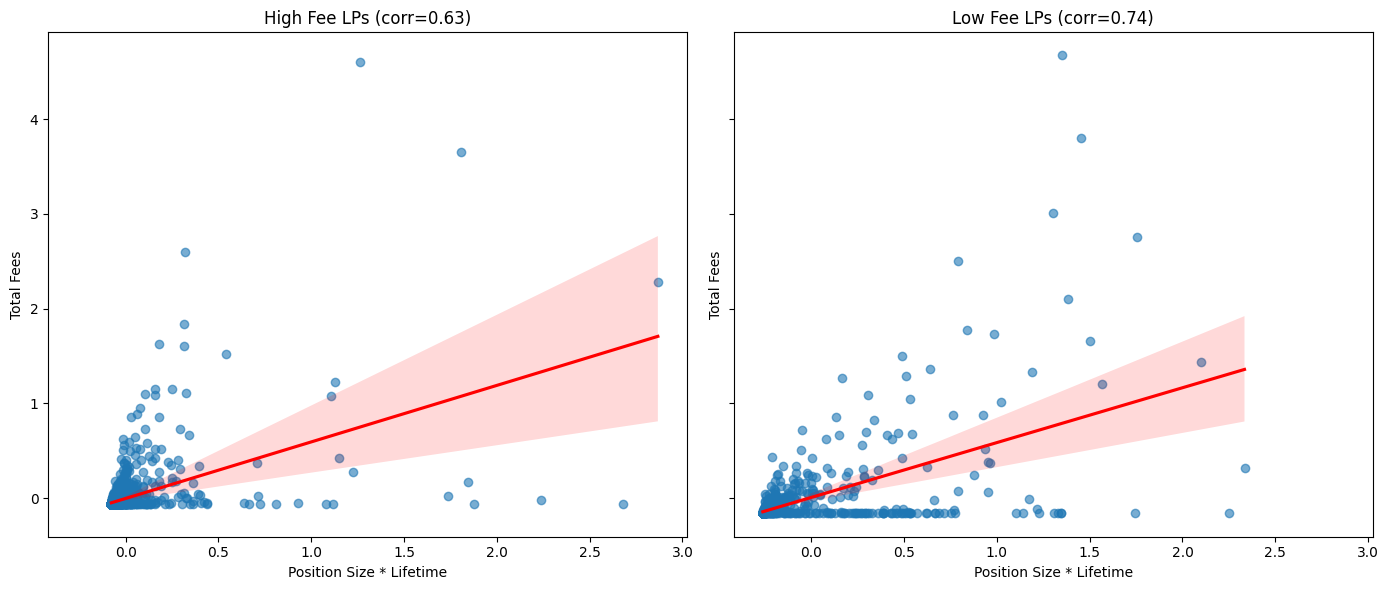

In [32]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6),sharey=True,sharex=True)



high_lps['fee_z'] = stats.zscore(high_lps.total_fees)
low_lps['fee_z'] = stats.zscore(low_lps.total_fees)
high_lps['lifetime_z'] = stats.zscore(high_lps['position_size*lifetime'])
low_lps['lifetime_z'] = stats.zscore(low_lps['position_size*lifetime'])

high_lps_ = high_lps[abs(high_lps.lifetime_z) < 3]
low_lps_ = low_lps[abs(low_lps.lifetime_z) < 3]

sns.regplot(
    data=high_lps_,
    x='lifetime_z',
    y='fee_z',
    ax=ax1,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
ax1.set_title(f'High Fee LPs (corr={high_corr:.2f})')

sns.regplot(
    data=low_lps_,
    x='lifetime_z',
    y='fee_z',
    ax=ax2,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)
ax2.set_title(f'Low Fee LPs (corr={low_corr:.2f})')

for ax in (ax1, ax2):
    ax.set_xlabel('Position Size * Lifetime')
    ax.set_ylabel('Total Fees')

plt.tight_layout()
plt.show()